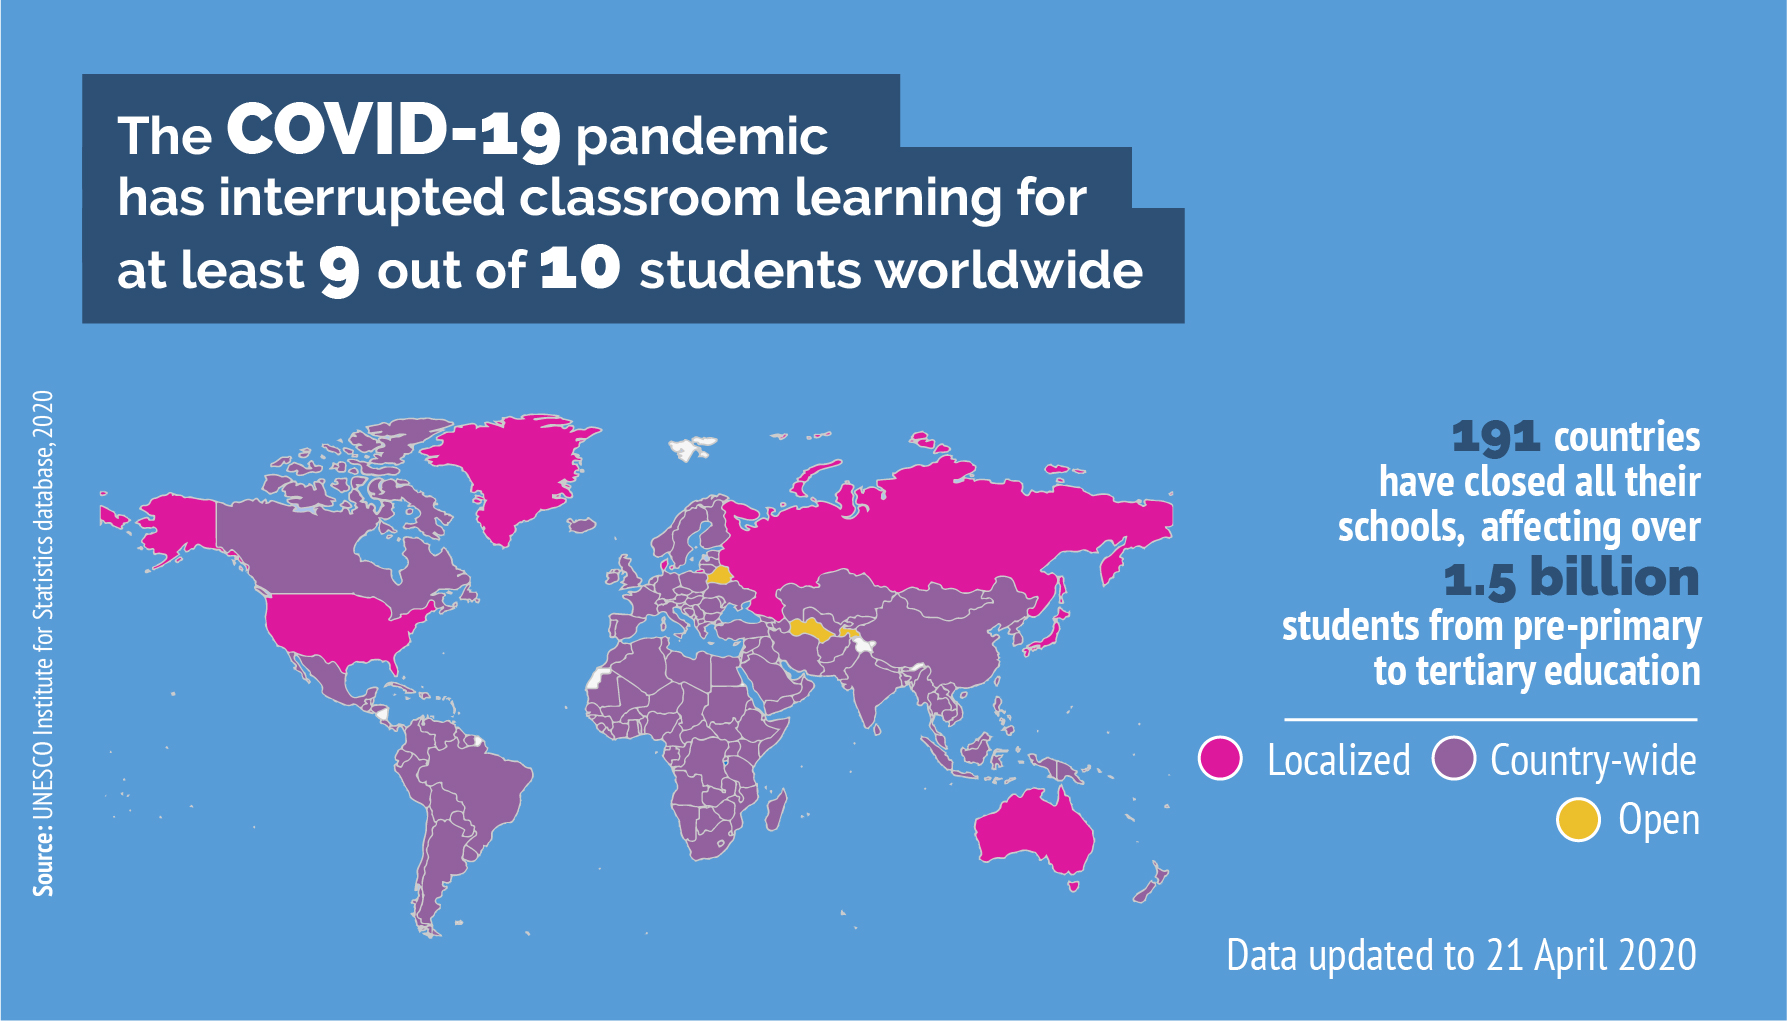

## 1. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np  
import seaborn as sns 
pal = sns.color_palette()
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
import glob
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout

## 2.1 Load the data - Districts data

In [ ]:
districts_data = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")

### 2.1.1 Exploratory Data Analysis

In [ ]:
districts_data.head()

#### We can notice that a lot of columns have missing values (almost all the columns except district_id)

In [ ]:
districts_data.shape

### There are 233 rows or district ids and 7 columns in the dataset

In [ ]:
districts_data.info()

In [ ]:
districts_data.dtypes

### All the columns except district_id are object types

In [ ]:
districts_data = districts_data.drop_duplicates()

In [ ]:
len(districts_data)

#### We checked for duplicates and dropped them, however the number of rows remained constant meaning that there are no duplicates in the original data

### 2.1.2 Data Visualization

In [ ]:
plt.figure(figsize=(12,10));
sns.countplot(x=districts_data.state);
plt.xticks(rotation=90);

### State wise distribution shows that Illinois, Utah, Connecticut and Massachusetts have the maximum data points

In [ ]:
districts_data["state"].value_counts().head(15).plot(kind = 'pie', autopct='%1.1f%%', figsize=(10, 10), startangle=0).legend();

In [ ]:
plt.figure(figsize=(12,10));
sns.countplot(x=districts_data.locale);
plt.xticks(rotation=90);

#### Distribution of locale shows that maximum data entries belong to Suburb locale

In [ ]:
districts_data["locale"].value_counts().head(10).plot(kind = 'pie', autopct='%1.1f%%', figsize=(10, 10)).legend();

In [ ]:
sns.countplot(data= districts_data, x = "pct_black/hispanic");
plt.show();

#### Maximum districts have black and hispanic population upto maximum of 20%

In [ ]:
sns.countplot(data= districts_data, x = "pct_free/reduced");
plt.show();

#### Maximum districts have about 20-40% students eligible for free or reduced price lunch

In [ ]:
sns.countplot(data= districts_data, x = "county_connections_ratio");
plt.show();

#### Maximum districs have high speed connection ratio

In [ ]:
plt.figure(figsize=(12,10));
sns.countplot(x=districts_data.pp_total_raw);
plt.xticks(rotation=90);

#### Per pupil total expenditure in majority of the districts is in the range of 8K-10K dollars

## 2.2 Load the data - Products data

In [ ]:
products_data = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
#products_data

### 2.2.1 Exploratory Data Analysis

In [ ]:
products_data.head()

In [ ]:
plt.tight_layout();
products_data["Sector(s)"].value_counts().head(10).plot(kind = 'pie', autopct='%1.1f%%', 
                                                        figsize=(10, 10), startangle=0,
                                                        labeldistance=1.1,pctdistance=0.5).legend();

#### The products are used maximum in PreK-12 sector

In [ ]:
plt.figure(figsize=(12,10));
sns.countplot(x=products_data["Primary Essential Function"]);
plt.xticks(rotation=90);

#### Primary essential function is the digital learning platform 

## 2.3 Load the data - Engagement data

In [ ]:
CSV_files=pd.DataFrame()
address = glob.glob('../input/learnplatform-covid19-impact-on-digital-learning/engagement_data/*.csv')
count=0
for i in address:
    with open(i, "rb") as data_of_files:
        data=pd.read_csv(data_of_files)
        CSV_files=pd.concat([CSV_files,data], axis=0)
        count=count+1
        if count==233:
            break  
CSV_files

In [ ]:
CSV_files.hist(figsize=(20,20),bins = 20, color="blue")
plt.title("Numeric Features Distribution");
plt.show();

In [ ]:
colormap = plt.cm.magma
plt.figure(figsize=(14,12));
plt.title('Pearson Correlation of Features', y=1.05, size=15);
sns.heatmap(CSV_files.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);

#### Percentage of students in the district have at least one page-load event of a given product (pct_access) and on a given day is one of the main drivers for engagement index

In [ ]:
data_total = CSV_files.isnull().sum()
data_percent = ((CSV_files.isnull().sum()/CSV_files.shape[0])*100).round(2)
missing_data = pd.concat([data_total, data_percent],
                                axis=1, 
                                keys=['Data_Total', 'Data_Percent %'],
                                sort = True)
missing_data.style.bar(color = ['red'])

#### Maximum missing value is in engagement index, however since it has very high correlation with pct_access (which has lesser missing values), we can use this relationship as a proxy to impute the missing values

## 2.4 Merge the data

In [ ]:
CSV_files['time'] = pd.to_datetime(CSV_files['time'])

In [ ]:
print(products_data["LP ID"].nunique())
print(CSV_files["lp_id"].nunique())

In [ ]:
products_engagement_data = pd.merge(products_data,CSV_files, 
                                    left_on='LP ID', right_on='lp_id')
products_engagement_data.head()

In [ ]:
del CSV_files

In [ ]:
path = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[4].split(".")[0]
    df["district_id"] = district_id
    li.append(df)
    
engagement_data = pd.concat(li)
engagement_data = engagement_data.reset_index(drop=True)
engagement_data.head()

In [ ]:
print(engagement_data["district_id"].nunique())
print(districts_data["district_id"].nunique())

In [ ]:
engagement_data["district_id"] = engagement_data["district_id"].astype(str).astype(int)
districts_engagement_data = pd.merge(districts_data, engagement_data, left_on='district_id', right_on='district_id')
districts_engagement_data.head()

In [ ]:
def plot_time_series(df,col1,col2,col3):
    max_list = df[[col1,col2]]\
        .groupby([col1])[col2].mean()\
        .sort_values(ascending=False).index[:5].tolist()

    df = df[df[col1].isin(max_list)]\
                    .reset_index(drop=True)[[col3, col1, col2]]
    df = df.pivot_table(index=col3, columns=col1, values=col2)

    fig = px.line(df, facet_col=col1, facet_col_wrap=1, width=800, height=800)
    fig.update_layout(
                      title=(col1 + " , " + col2 + " , " + col3).title(),
                      title_x=0.39,
                      template="plotly",
                      paper_bgcolor='#f5f7f7',
                      font = {'family': 'Serif', 'size': 15}
                     )
    fig.show()

In [ ]:
plot_time_series(districts_engagement_data,"state","pct_access","time")
plot_time_series(districts_engagement_data,"state","engagement_index","time")
plot_time_series(districts_engagement_data,"locale","pct_access","time")
plot_time_series(districts_engagement_data,"locale","engagement_index","time")

## 2.5 Geospatial Analysis

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Ruch")

def feature_generation(df):
    lat=[]
    long=[]
    for i in df['state']: 
        location = geolocator.geocode(i)
        try:
            lat.append(location.latitude)
            long.append(location.longitude)
        except:
            lat.append("NA")
            long.append("NA")
    df['Latitude'] = lat
    df['Longitude'] = long
    
    return df

def map_df(df,col1,col2):
    df = pd.DataFrame(df[[col1,col2]]\
            .groupby([col1])[col2].mean()\
            .sort_values(ascending=False)[:20]).reset_index()
    
    df = feature_generation(df)
    
    return df

state_access = map_df(districts_engagement_data, "state", "pct_access")
state_engagement_index = map_df(districts_engagement_data, "state", "engagement_index")

### 2.5.1 Base Map

In [ ]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
north_america_map = folium.Map(location=[38.9, -77.05], tiles='Stamen Watercolor', zoom_start=3)
north_america_map

### 2.5.2 State and Percentage Access (Top 20)

In [ ]:
import math
mc = MarkerCluster()
for idx, row in state_access.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        popup = """
        State : <b>%s</b><br>
        Percentage Access : <b>%s</b><br>
        """ % (row['state'], row['pct_access'])
        mc.add_child(Marker([row['Latitude'], row['Longitude']],tooltip=popup))
    north_america_map.add_child(mc)
north_america_map

#### Further updates coming soon, stay tuned, thanks for your patience so far